In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io
import shutil
import flg_diagnostics

MainProcess


In [2]:
res_dir = fls.result_dir + '/many_abbr_res/'
temp_dir = fls.temp_dir + '/temptemp/'
fls.remove_and_make_dir(res_dir)
fls.remove_and_make_dir(temp_dir)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-2/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-3/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)

'd:/flagellar/results//many_abbr_res/'

In [3]:
# Read results from vast.ai
files = glob.glob(res_dir + 'Baseline*ca1*.pickle') + glob.glob(res_dir + 'Baseline*0ac1*.pickle')
data_list = []
missing_values = dict()
modifier_values_list = []
for f in files:    
    if 'L_' in f:
        continue
    print(f)
    data_list.append(fls.dill_load(f)    )
    #if not (data_list[-1].modifier_values['seed']>=5): print('skip'); continue
    data_list[-1].modifier_values['local_mode'] = ('L_' in f)
    modifier_values_list.append(data_list[-1].modifier_values)
    #print(modifier_values_list[-1])
    for key,value in data_list[-1].modifier_dict.items():
        missing_values[key] = value.missing_value
    if not data_list[-1].exception == 0:
        print(data_list[-1].exception)
        del data_list[-1]
        del modifier_values_list[-1]
    #print(modifier_values_list[-1])

d:/flagellar/results//many_abbr_res\Baseline_0_ca1865f2_940 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1000_ca1865f2_911 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1001_ca1865f2_893 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1002_ca1865f2_892 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1003_ca1865f2_883 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1004_ca1865f2_878 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1005_ca1865f2_876 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1006_ca1865f2_897 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1007_ca1865f2_882 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1008_ca1865f2_884 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1009_ca1865f2_879 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1010_ca1865f2_875 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1011_ca1865f2_891 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1012_ca18

In [4]:
import flg_model
dicts = []
dicts_kaggle_comp = []
for data, modifier_values in zip(data_list, modifier_values_list):
    d = copy.deepcopy(missing_values)
    #print(modifier_values)
    for key,value in modifier_values.items():
        d[key] = value
        #print(d)

    if d['n_ensemble']==4 and d['concentration']==2:
        d['concentration']=1
        data.inferred_test_data = fls.dill_load(fls.result_dir + '/reinfer/' + str(d['seed']) + '.pickle')
        print('reloaded ', d['seed'])
    d['lr0_times_nepochs'] = d['lr0']*d['n_epochs']
    #print(d)
    #raise 'stop'
    # if predict_all:
    #     data.trained_model.data_after_step2 = data.inferred_test_data     
    #     data.trained_model.step3Output.threshold=-1
    #     data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value

    # Reinfer
    

    # false_conf = []
    # true_conf = []
    # for dd,r in zip(data.inferred_test_data, data.test_data):
    #     if len(r.labels)>0:
    #         true_conf.append(dd.labels['confidence'][0])
    #     else:
    #         false_conf.append(dd.labels['confidence'][0])
    # plt.figure()
    # plt.hist(true_conf,alpha=0.5)
    # plt.hist(false_conf,alpha=0.5)

    if data.inferred_test_data==0:
        d['cv_score'] = np.nan
    else:
        # model = data.untrained_model
        # model.state = 1
        # model.data_after_step2 = data.inferred_test_data
        # import io
        # import contextlib
        # model.step2Motors = flg_model.FindClustersMultiZ()
        # model.step2Motors.z_range = 4
        # model.run_in_parallel = False
        # with contextlib.redirect_stdout(io.StringIO()) as f:
        #     data.inferred_test_data = model.infer(data.test_data) 
        dat, test_data = flg_diagnostics.expand_and_reinfer(data.inferred_test_data, data.test_data, data.untrained_model.step3Output.select_motors, 0.7)
        metric = fls.score_competition_metric(dat, test_data)
        print(d['seed'], metric)
        d['cv_score'] = metric[2]
    #print(d['cv_score'])

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan
    d_kaggle_comp['local_mode'] = d['local_mode']

    #print(len(data.test_data))

    

    # if not d['cos_lr'] or not d['trust_neg']==1 or d['use_pretrained_weights']:
    #     print('skip')
    #     continue
    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue

    
    
    
    for partial in fls.DataSelector().datasets:
        try:
            data_selector = fls.DataSelector()
            data_selector.datasets = [partial]
            d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
        except:
            d['cv_score_' + partial] = np.nan

    try:
        data_selector = fls.DataSelector()
        data_selector.datasets = ['ycw', 'mba', 'aba']
        d['cv_score_other'] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    except:
        d['cv_score_other'] = np.nan

    dicts_kaggle_comp.append(d_kaggle_comp)
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

0 (0.5664739884393064, 0.98, 0.8551483420593369)
1000 (0.5335276967930029, 0.915, 0.800524934383202)
1001 (0.5043731778425656, 0.865, 0.7567804024496938)
1002 (0.5100864553314121, 0.885, 0.7715780296425457)
1003 (0.5086705202312138, 0.88, 0.7678883071553229)
1004 (0.4812680115273775, 0.835, 0.7279860505666957)
1005 (0.501466275659824, 0.855, 0.7493426818580193)
1006 (0.5100864553314121, 0.885, 0.7715780296425457)
1007 (0.4827586206896552, 0.84, 0.7317073170731707)
1008 (0.501466275659824, 0.855, 0.7493426818580193)
1009 (0.5043731778425656, 0.865, 0.7567804024496938)
1010 (0.501466275659824, 0.855, 0.7493426818580193)
1011 (0.5072463768115942, 0.875, 0.7641921397379913)
1012 (0.5100864553314121, 0.885, 0.7715780296425457)
1013 (0.5575221238938053, 0.945, 0.8296751536435469)
1014 (0.5100864553314121, 0.885, 0.7715780296425457)
1015 (0.530791788856305, 0.905, 0.7931638913234005)
1016 (0.5100864553314121, 0.885, 0.7715780296425457)
1017 (0.5114942528735632, 0.89, 0.7752613240418118)
1018 

In [5]:
# Load Kaggle results
#if predict_all:
#    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
#else:
kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [6]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    #if predict_all:
    #    name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

Added score of 0.728 for Baseline_5_ca1865f2
Added score of 0.68 for Baseline_6_ca1865f2
Added score of 0.66 for Baseline_7_ca1865f2
Added score of 0.708 for Baseline_8_ca1865f2
Added score of 0.68 for Baseline_9_ca1865f2


In [7]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i] and not p_kaggle_comp['local_mode'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i] and not p['local_mode'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [8]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(kaggle_results_file)

In [9]:
# for i_i in range(len(p)):
#     if p['seed'][i_i] in [0,2,3,4,5,7,8,10]:
#         p.loc[i_i,'k_score']=np.nan

In [10]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,n_ensemble,concentration,extra_data,trust_neg,trust_extra,negative_label_threshold,target_voxel_spacing,blur_xy,blur_z,...,seed,local_mode,lr0_times_nepochs,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_other,k_score
0,0,2,1,True,2,3,0.613489,20.204868,15.495829,15.0,...,0,False,0.027797,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.855148,0.931818,0.943517,0.808
1,34,2,1,True,1,2,0.647523,20.720798,43.459483,0.0,...,1,False,0.030775,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.815170,0.904977,0.933076,0.737
2,49,2,1,True,2,1,0.614925,24.071129,17.757478,15.0,...,2,False,0.022556,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.800525,0.874439,0.927835,0.689
3,50,2,1,True,2,0,0.611841,24.006372,32.464861,0.0,...,3,False,0.033772,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.767888,0.895197,0.885417,0.651
4,51,2,1,True,2,4,0.625566,24.881219,17.425081,15.0,...,4,False,0.031892,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.818815,0.913242,0.943517,0.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,45,2,1,True,2,1,0.629216,21.605582,22.223824,15.0,...,2010,False,0.019656,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.811518,0.900901,0.933076,NaN
60,46,2,1,True,2,3,0.612595,23.413806,22.115247,15.0,...,2011,False,0.046298,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.807860,0.896861,0.927835,NaN
61,47,2,1,True,2,1,0.603661,21.786468,23.576356,15.0,...,2012,False,0.028489,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.815170,0.919283,0.933076,NaN
62,48,2,1,True,1,1,0.613091,20.982305,43.203948,15.0,...,2013,False,0.030906,Baseline,ca1865f298d5d1c2afba3d026939a64889d85062,False,0.764192,0.873362,0.885417,NaN


In [11]:
# p_part = p[p['n_ensemble']==4]
# print(p_part['cv_score'])
# print(np.mean(p_part['cv_score']), np.std(p_part['cv_score']))

In [34]:
to_plot = copy.deepcopy(p).columns.to_list()[1:-7]
main = np.logical_and(np.logical_not(p['use_missing_value']), p['degrees']>0)


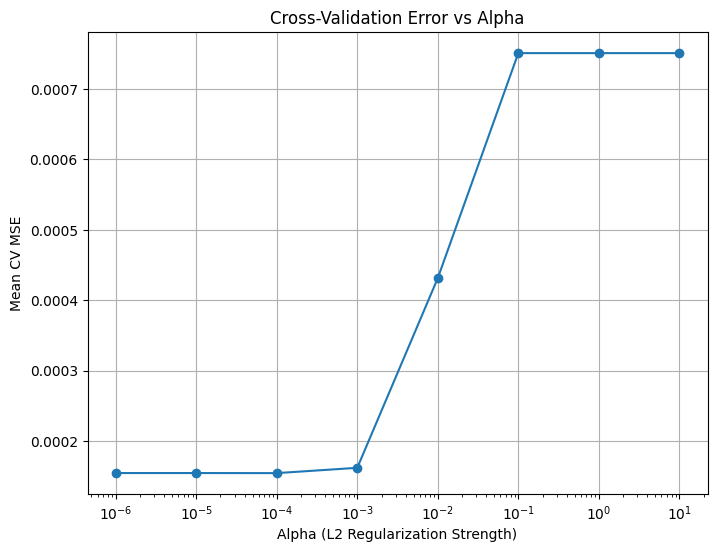

Best alpha (lambda): 0.0001
Best CV Mean RMSE: 0.012435183544044994
Final coefficients: [ 0.0055713   0.00665634  0.00709152 -0.02449489  0.00680011]
Index(['mixup', 'weight_decay', 'clip_value', 'trust_extra0', 'model_m'], dtype='object')
Final intercept: [0.80100318]
0.010452921235380691
cv_score    0.026595
dtype: float64


C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

which='cv_score'
todo = np.logical_and(main, np.logical_not(np.isnan(p[which].to_numpy())))
#y = p[[which]][todo].to_numpy()-p[['cv_score']][todo].to_numpy()
y = p[[which]][todo]

# n_ensemble = 1
# X = p[['degrees', 'scale_moving_std_size_fac', 'n_epochs', 'trust_extra', 'absolute_threshold', 'z_range', 'concentration', 'erasing', 'scale_moving_std']][todo]
# X.loc[np.logical_not(p['scale_moving_std'][todo]), 'scale_moving_std_size_fac'] = np.mean(X.loc[(p['scale_moving_std'][todo]), 'scale_moving_std_size_fac'])
# X['trust_neg2'] = (p['trust_neg']==2)[todo]

# n_ensemble = 4 offline
# X = p[['fliplr']][todo]
# X['trust_extra0'] = (p['trust_extra']==0)[todo]
# #X['trust_extra'] = (p['trust_extra']==0)[todo]
# X['yolov8'] = np.logical_or(p['model_name']=='yolov8m',p['model_name']=='yolov8s')

# online
# X = p[['fliplr']][todo]

# ca1 offline
X = p[['mixup', 'weight_decay', 'clip_value']][todo]
#X['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
X['trust_extra0'] = (p['trust_extra']==0)[todo]
#X['z_range_m1'] = (p['z_range']==-1)[todo]
#X['trust_neg2'] = (p['trust_neg']==2)[todo]
X['model_m'] = (['m' in x for x in p['model_name'][todo]])
#X['model_11'] = (['11' in x for x in p['model_name']])

# Define candidate alphas (lambdas)
alphas = np.logspace(-6, 1, 8)

# Define pipeline explicitly with named steps
pipeline = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("ridge", sklearn.linear_model.Lasso())
])

# Define parameter grid (for Ridge alpha)
param_grid = {
    "ridge__alpha": alphas
}

# GridSearchCV with 5-fold cross-validation
grid_search = sklearn.model_selection.GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=len(y),
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Extract results
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']  # Convert to positive MSE
alphas_tested = results['param_ridge__alpha'].data.astype(float)

# Plot CV error as function of alpha
plt.figure(figsize=(8, 6))
plt.semilogx(alphas_tested, mean_test_scores, marker='o')
plt.xlabel("Alpha (L2 Regularization Strength)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validation Error vs Alpha")
plt.grid(True)
plt.show()

# Report best alpha
best_alpha = grid_search.best_params_['ridge__alpha']
print("Best alpha (lambda):", best_alpha)
print("Best CV Mean RMSE:", np.sqrt(-grid_search.best_score_))

# Create a new pipeline with the best alpha
final_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("lasso", sklearn.linear_model.Lasso(alpha=best_alpha))
])

# Fit to full dataset
final_model.fit(X, y)

y_pred = final_model.predict(X)
p['residual'] = np.nan
#p.loc[todo,'residual'] = (y-y_pred).to_numpy()
p.loc[todo,'residual'] = (np.ravel(y)-y_pred)

# (Optional) Print final coefficients and intercept
lasso_model = final_model.named_steps['lasso']
print("Final coefficients:", lasso_model.coef_)
print(X.columns)
print("Final intercept:", lasso_model.intercept_)

print(np.std(p['residual'][todo]))
print(np.std(y))

In [83]:
import statsmodels.api as sm
X_norm = (X - X.mean()) / X.std(ddof=0)
#X_norm = X
X_const = sm.add_constant(X_norm)
model = sm.OLS(y.astype(float), X_const.astype(float)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               cv_score   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     30.67
Date:                Tue, 20 May 2025   Prob (F-statistic):           1.55e-10
Time:                        16:48:39   Log-Likelihood:                 106.84
No. Observations:                  34   AIC:                            -201.7
Df Residuals:                      28   BIC:                            -192.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8010      0.002    405.605   

In [76]:
4/(2*53)

0.03773584905660377

                            OLS Regression Results                            
Dep. Variable:                k_score   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     7.478
Date:                Tue, 20 May 2025   Prob (F-statistic):             0.0411
Time:                        16:46:16   Log-Likelihood:                 14.598
No. Observations:                   7   AIC:                            -25.20
Df Residuals:                       5   BIC:                            -25.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7120      0.521     -1.366      0.2

C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


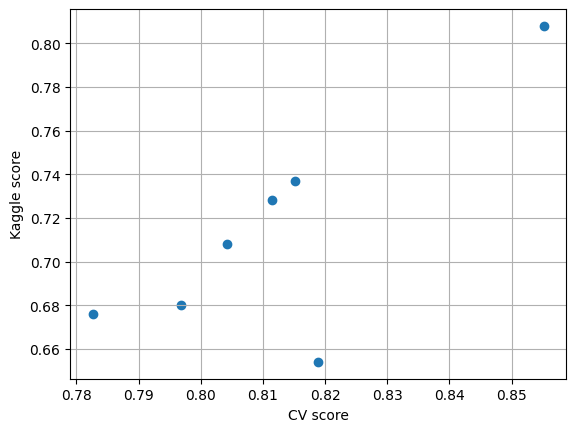

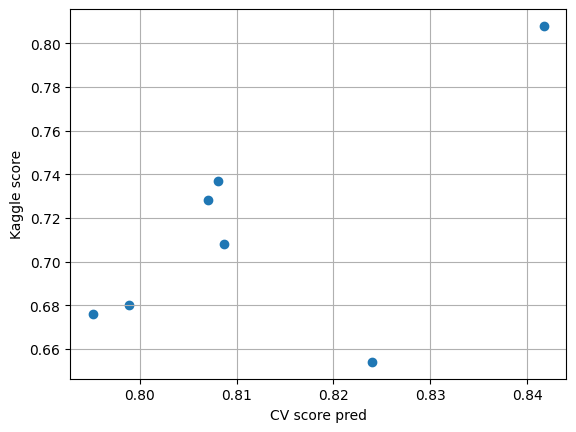

In [77]:
def compare_k_cv(cv_score, name):
    plt.figure()
    y = p['k_score'][main]
    todo = np.logical_not(np.isnan(y))
    plt.scatter(cv_score[todo], y[todo])
    plt.grid(True)
    plt.xlabel(name)
    plt.ylabel('Kaggle score')
    XX = pd.DataFrame({'x':cv_score[todo]})
    XX_const = sm.add_constant(XX)
    model = sm.OLS((y[todo]).astype(float).reset_index().drop('index',axis=1), XX_const.astype(float).reset_index().drop('index',axis=1)).fit()
    print(model.summary())

    
compare_k_cv(p['cv_score'][main], 'CV score')
compare_k_cv(y_pred, 'CV score pred')

In [78]:
# X_alt = copy.deepcopy(X)
# for c in X_alt.columns:
#     X_alt[c] = 0
# X_alt['lr0_times_nepochs'] = X['lr0_times_nepochs']
# X_alt['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
# y_pred_alt = final_model.predict(X_alt)
# plt.scatter(X_alt['lr0_times_nepochs'], y_pred_alt)

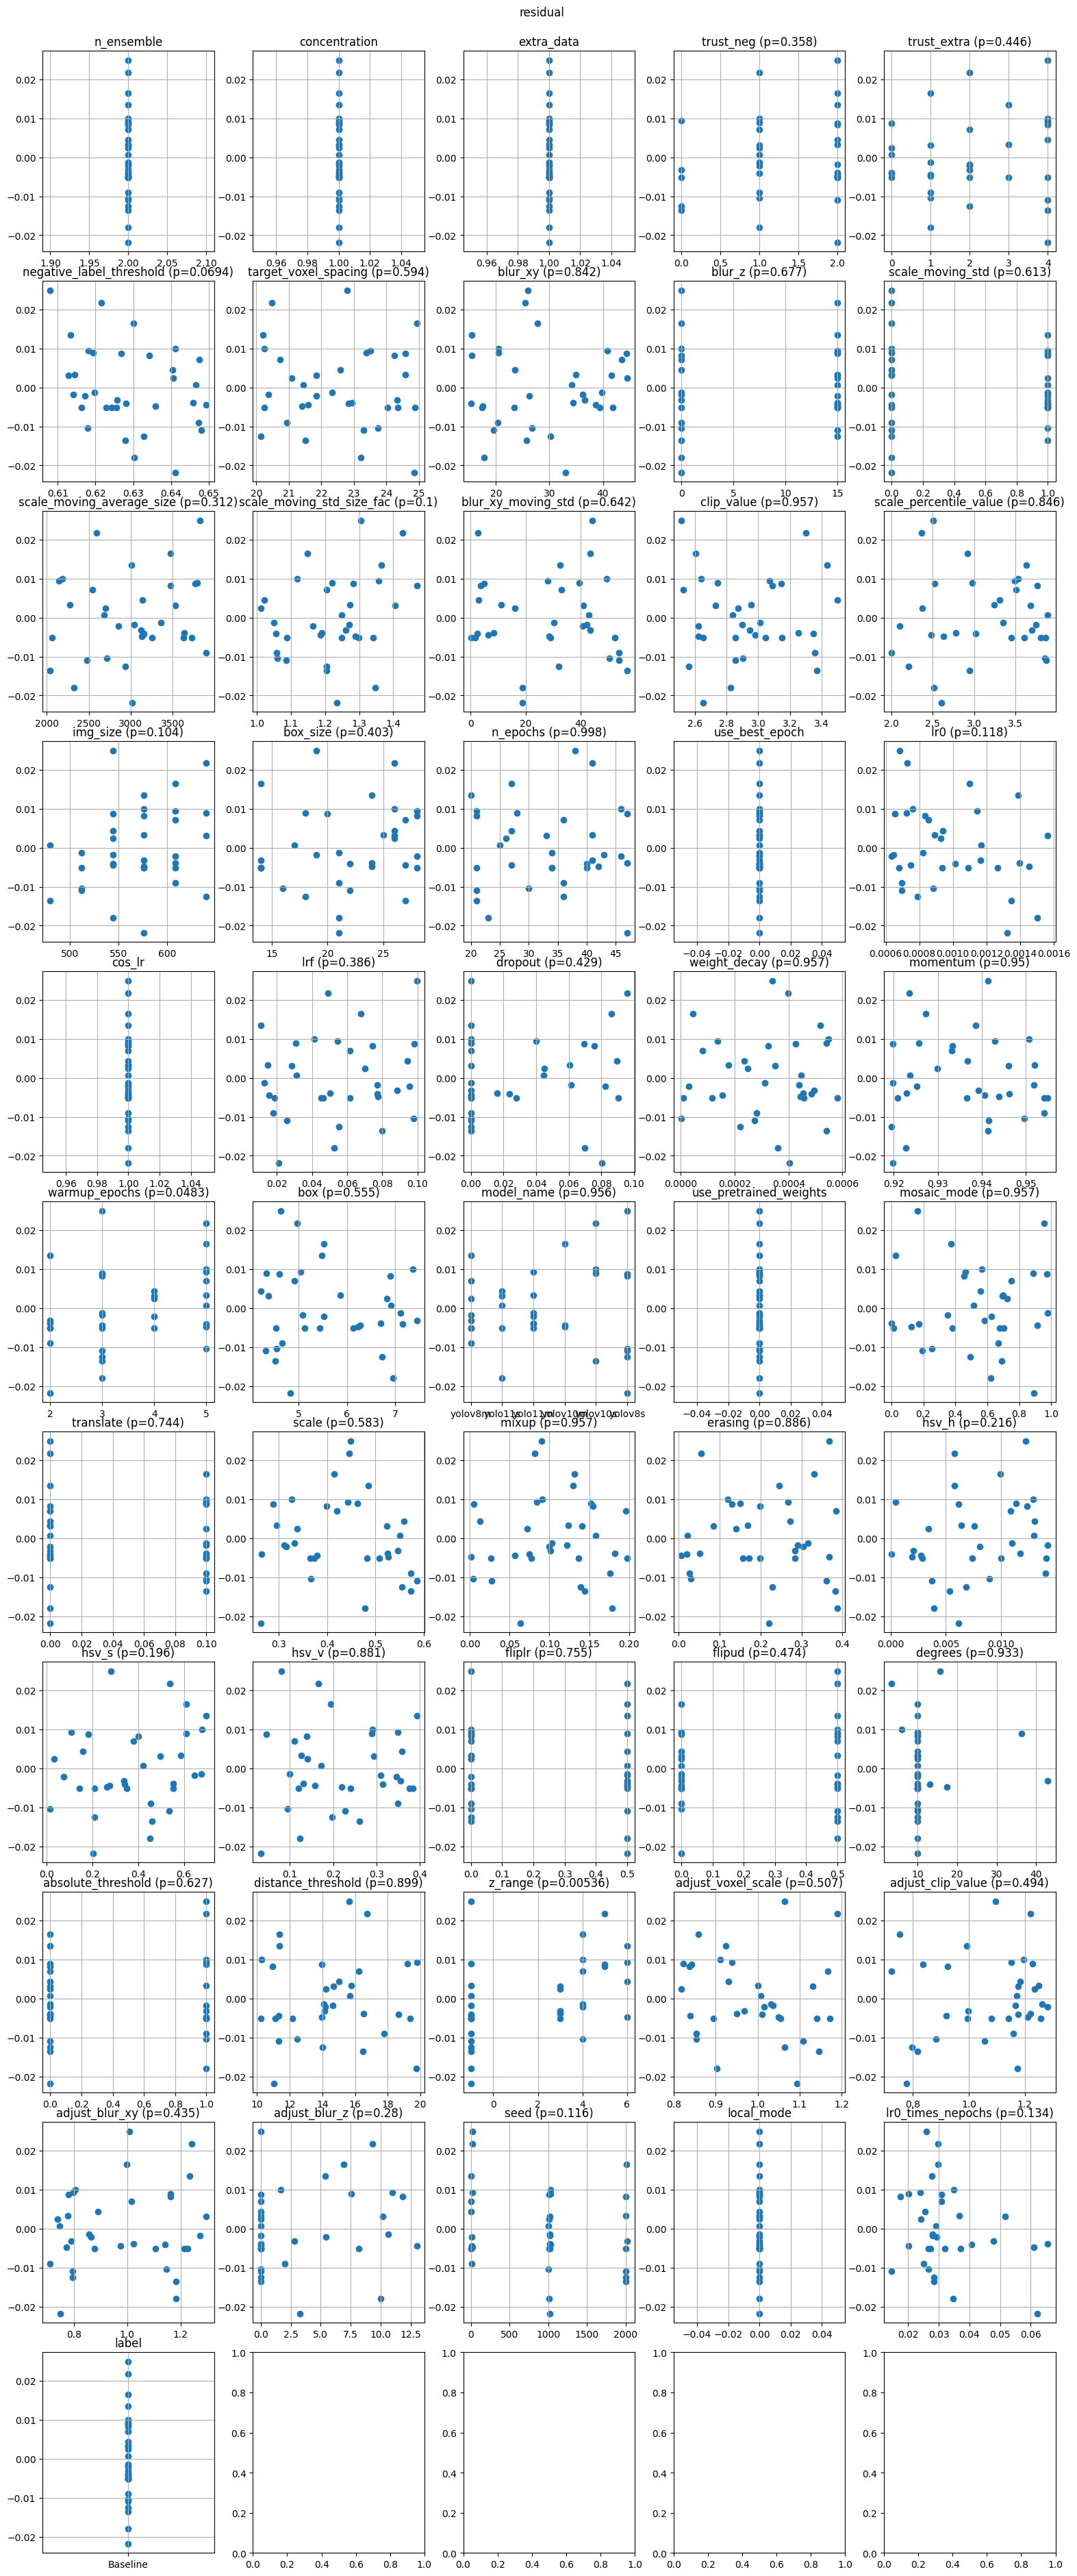

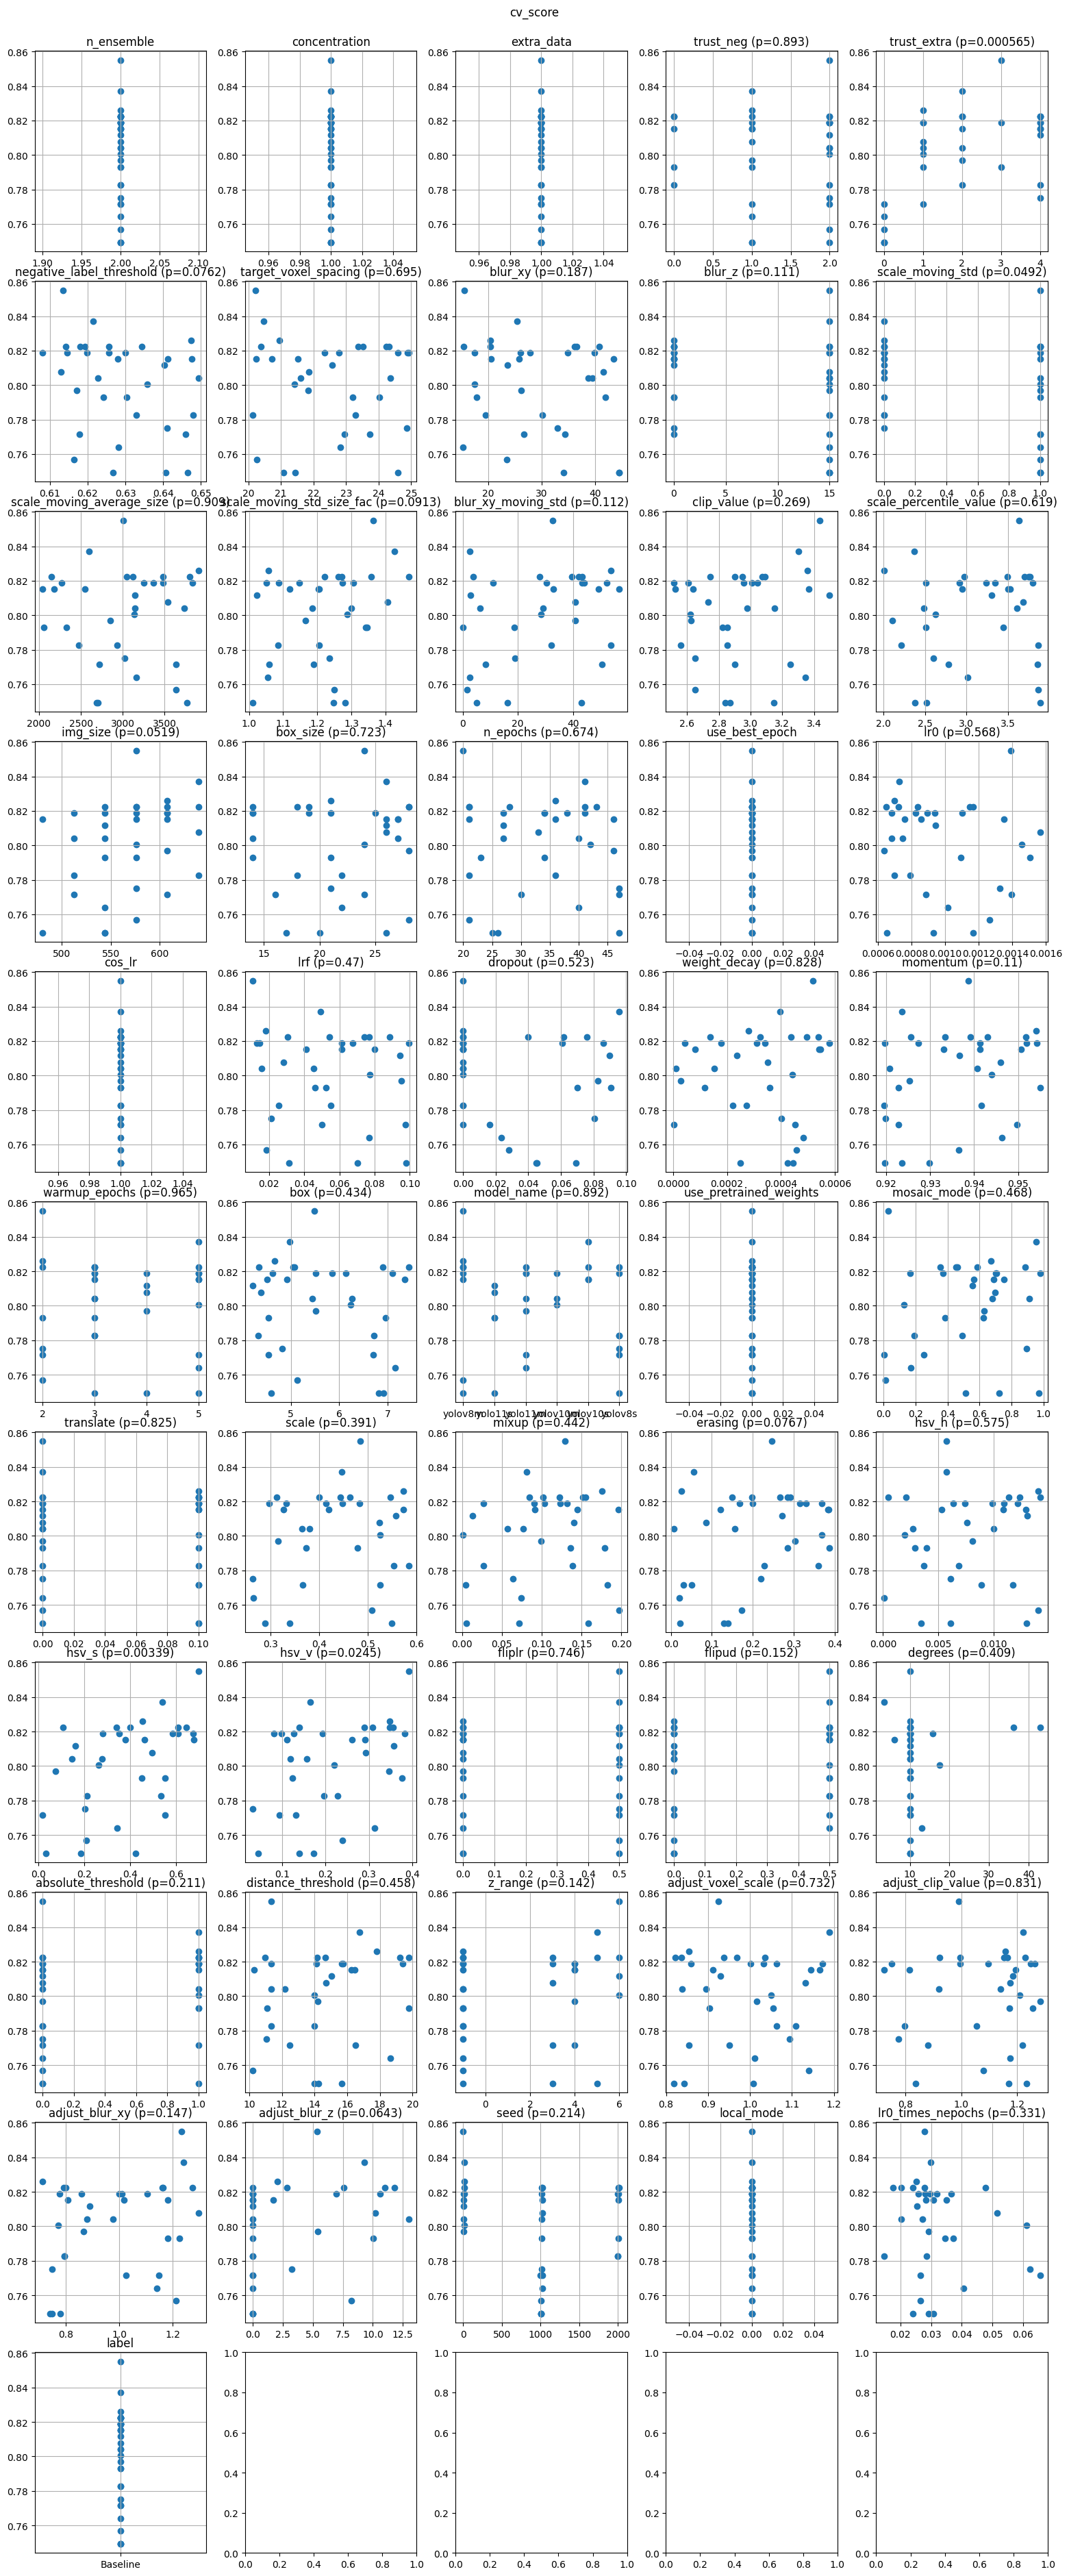

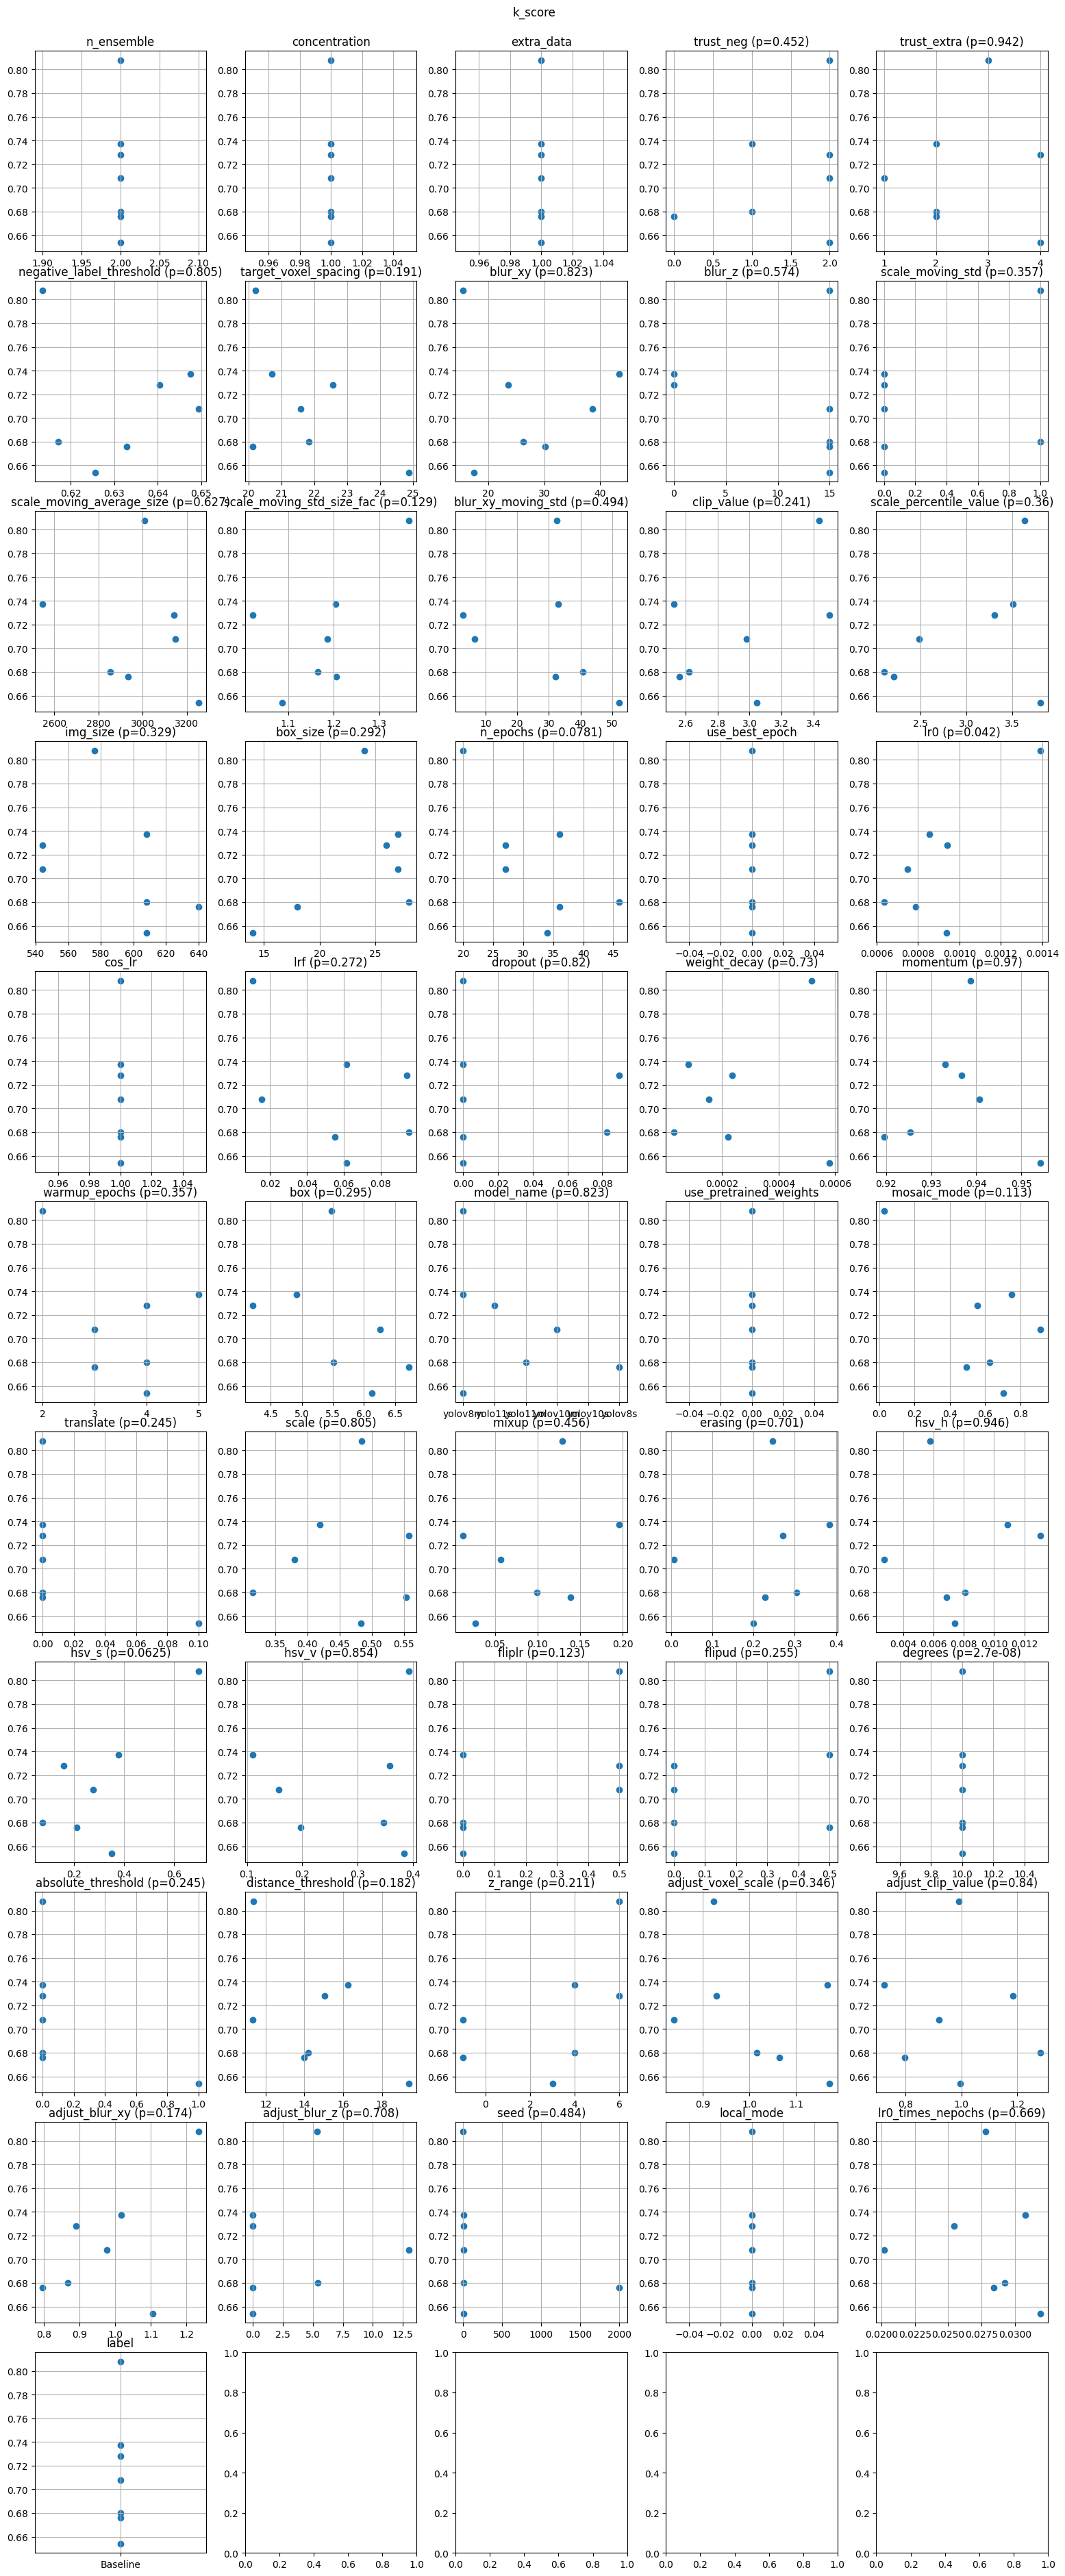

In [79]:
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
r = np.random.default_rng(seed=0)
#main = p['model_name']=='yolov8l'
for y_val in p.columns[[-1,-5,-2]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        #p[y_val] = r.normal(size=p[y_val].shape)
        plt.scatter(p[d][main], p[y_val][main])
        #if y_val == 'k_score':
         #   plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [19]:
# from pptx import Presentation
# from pptx.util import Inches

# prs = Presentation()
# blank = prs.slide_layouts[6]  # a blank slide layout

# for i, fig in enumerate(figs):
#     # save each figure to disk
#     img_path = f"figure_{i+1}.png"
#     fig.savefig(img_path, dpi=300, bbox_inches='tight')

#     # add a new slide, then add the image to it
#     slide = prs.slides.add_slide(blank)
#     slide.shapes.add_picture(
#         img_path,
#         Inches(1), Inches(1),          # left, top margins
#         width=Inches(8)                # scale width (height auto)
#     )

#     os.remove(img_path)

# prs.save("run_many_models_results.pptx")